### Задание 1 - по тетрадке sem01_autograd.

1. Добавить Bias и посчитать для них градиенты.
2. Сравнить градиенты с тем, как считает PyTorch AutoGrad.

**Из тетрадки autograd**

In [ ]:
batch_size = 64
input_size = 3 # кол-во признаков (x = 3)
hidden_size = 2 # скрытый слой (2 нейрона)
output_size = 1 # 1 нейрон
# Тут создается рандмные input and output data
x = torch.randn(batch_size, input_size, device=device, dtype=dtype) # сгенерируем случайные матрицы
y = torch.randn(batch_size, output_size, device=device, dtype=dtype)

# Также рандомно инизиализируются весы
w1 = torch.randn(input_size, hidden_size, device=device, dtype=dtype)
w2 = torch.randn(hidden_size, output_size, device=device, dtype=dtype)

learning_rate = 1e-6
# Цикл обучения выполняется 500 итераций
for t in range(500):
# прямой проход
#  h_1 = x.mm(w1): Вычисляется выход первого слоя путем умножения матриц входных данных (x) и весов первого слоя (w1).  .mm() — это умножение матриц
    # Forward pass: compute predicted y
    h_1 = x.mm(w1) # матрица выхода с 1 слоя (w1)
    h_relu = h_1.clamp(min=0) # h_relu = h_1.clamp(min=0): Применяется функция ReLU — заменяет все отрицательные значения на 0
    out = h_relu.mm(w2) # выход нейронной сети,  out = h_relu.mm(w2): Вычисляется выход сети путем умножения матриц выхода ReLU слоя и весов второго слоя (w2)

# Вычисление функции потерь (MSE)
    loss = (out - y).pow(2).sum().item()
# Обратный проход (backword) - ручной рассчет градиентов
    # Backward pass: y pred = dloss out
    dloss_out = 2 * (out - y)
    grad_w2 = h_relu.t().mm(dloss_out) # посчитали градиент по w2
    # считаем градиент для весов и слоя w2
    grad_hrelu = dloss_out.mm(w2.t()) # вес находится во внутренней функции
    grad_hrelu[h_1 < 0] = 0 # производна по RELU
    grad_w1 = x.t().mm(grad_hrelu) # получаем градиент 1
# Обновление весов
    w1 -= learning_rate * grad_w1 # веса первого слоя обновляются с использованием градиентного спуск
    w2 -= learning_rate * grad_w2
    if t % 100 == 99:
        print(f'Loss on iteration {t} = {loss}')

Результаты по тетрадке autograd:

Loss on iteration 99 = 240.94204711914062

Loss on iteration 199 = 229.81411743164062

Loss on iteration 299 = 219.60003662109375

Loss on iteration 399 = 210.20443725585938

Loss on iteration 499 = 201.539794921875

На каждой итерация функция потерь уменьшается, модель постепенно улучшает свои пронозы. Однако постепенно модель замедляется, скорее всего из-за маленького learning rate (1e-6). Возможно, 500 итераций также недостаточно для достижения сходимости.

В этом коде нет bias (смещения), которое влияет на активационную функцию нейрона и на результаты. Bias сдвигает активационную функцию вдоль оси x. Если bias положителен, кривая сдвигается влево, а если отрицателен – вправо. Смещение также изменяется при рассчете градиентов.

Кроме того, здесь не настроены параметры Autograd, что также вообще не улучшает результат, он нужен для автоматического вычисления производных. Он позволяет сохранять в памяти историю последовательных вычислений в прямом направлении, а затем воспроизводить эти вычисления в обратном порядке для автоматического вычисления градиентов.


**Тетрадка hw01**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
batch_size = 64
input_size = 3
hidden_size = 2
output_size = 1
# Задание: добавить bias(смещение)

In [ ]:
# Опять же создам рандомные  input и output data
x = torch.randn(batch_size, input_size, device='cpu', dtype=torch.float32)
y = torch.randn(batch_size, output_size, device='cpu', dtype=torch.float32)
# Тоже рандомно инициализирую весы, но поставлю параметы
# require_grad = Без этого параметра PyTorch не сможет вычислить градиенты и обновить w1, w2, b1, и b2, и обучение будет невозможно
w1 = torch.randn(input_size, hidden_size, device='cpu', dtype=torch.float32, requires_grad=True)
w2 = torch.randn(hidden_size, output_size, device='cpu', dtype=torch.float32, requires_grad=True)
# Добавляю смещение (bias):
b1 = torch.randn(hidden_size, device='cpu', dtype=torch.float32, requires_grad=True)
b2 = torch.randn(output_size, device='cpu', dtype=torch.float32, requires_grad=True)

# Pytorch autograd
loss_fn = torch.nn.MSELoss(reduction='sum') #Функция MSELoss посчитает MSE для каждого элемента и вернет сумму этих ошибок (суммарное MSE)
learning_rate = 1e-6
# Оптимизатор
# оптимизаторы — это алгоритмы, которые точно настраивают параметры нейронной сети во время обучения. Их цель — минимизировать функцию потерь, что в конечном итоге приведет к повышению производительности.
optimizer = torch.optim.Adam([w1, b1, w2, b2], lr=learning_rate)

for t in range(500):
 # Прямой проход с добавлением bias
  hidden = x.mm(w1) + b1  #  bias
  hidden = hidden.clamp(min=0)  # ReLU
  y_pred = hidden.mm(w2) + b2  # bias ко второму слою
# MSE
  loss = loss_fn(y_pred, y)
  if t % 100 == 99:
    print(f'Loss on iteration {t} (AutoGrad) = {loss.item()}')
    # Forward pass: compute predicted y
  loss.backward()
  # Шаг оптимизации
  optimizer.step()

Loss on iteration 99 (AutoGrad) = 82.13227844238281
Loss on iteration 199 (AutoGrad) = 82.11222839355469
Loss on iteration 299 (AutoGrad) = 82.09185791015625
Loss on iteration 399 (AutoGrad) = 82.07149505615234
Loss on iteration 499 (AutoGrad) = 82.0512466430664


In [ ]:
# вижу, что модель очень быстро замедлилась, на итерациях результат меняется мало

In [ ]:
batch_size = 64
input_size = 3
hidden_size = 2
output_size = 1

In [ ]:
# Попробую занулить градиенты, возьму те же самые переменные
x_1 = torch.randn(batch_size, input_size, device='cpu', dtype=torch.float32)
y_1 = torch.randn(batch_size, output_size, device='cpu', dtype=torch.float32)
w_1 = torch.randn(input_size, hidden_size, device='cpu', dtype=torch.float32, requires_grad=True)
w_2 = torch.randn(hidden_size, output_size, device='cpu', dtype=torch.float32, requires_grad=True)
b_1 = torch.randn(hidden_size, device='cpu', dtype=torch.float32, requires_grad=True)
b_2 = torch.randn(output_size, device='cpu', dtype=torch.float32, requires_grad=True)

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-6
# Также использую оптимизатор
optimizer = torch.optim.Adam([w_1, b_1, w_2, b_2], lr=learning_rate)
for t in range(500):
  optimizer.zero_grad() # обнуление градиентов
  y_pred = (x_1.mm(w_1) + b_1).clamp(min=0).mm(w_2) + b_2
  loss = loss_fn(y_pred, y_1)
  if t % 100 == 99:
    print(t, loss.item())

  loss.backward()

  optimizer.step()

99 70.04204559326172
199 70.00381469726562
299 69.96563720703125
399 69.92781066894531
499 69.89025115966797


In [ ]:
print(optimizer.param_groups)

[{'params': [tensor([[ 1.3699,  2.1367],
        [-0.0671, -0.6781],
        [ 0.5239, -0.1822]], requires_grad=True), tensor([ 1.2668, -0.0354], requires_grad=True), tensor([[-0.4304],
        [ 0.0848]], requires_grad=True), tensor([0.2592], requires_grad=True)], 'lr': 1e-06, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None}]


In [ ]:
# C оптимизатором стало лучше, ошибка упала с  240 до 69, однако если присмотреться, то она почти не уменьшается, сейчас попробую поменять learning rate, попробую его увеличить

In [ ]:
batch_size = 64
input_size = 3
hidden_size = 2
output_size = 1

In [ ]:
# Попробую занулить градиенты, возьму те же самые переменные
x_1 = torch.randn(batch_size, input_size, device='cpu', dtype=torch.float32)
y_1 = torch.randn(batch_size, output_size, device='cpu', dtype=torch.float32)
w_1 = torch.randn(input_size, hidden_size, device='cpu', dtype=torch.float32, requires_grad=True)
w_2 = torch.randn(hidden_size, output_size, device='cpu', dtype=torch.float32, requires_grad=True)
b_1 = torch.randn(hidden_size, device='cpu', dtype=torch.float32, requires_grad=True)
b_2 = torch.randn(output_size, device='cpu', dtype=torch.float32, requires_grad=True)

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 0.1
# Также использую оптимизатор
optimizer = torch.optim.Adam([w_1, b_1, w_2, b_2], lr=learning_rate)
for t in range(500):
  optimizer.zero_grad() # обнуление градиентов
  y_pred = (x_1.mm(w_1) + b_1).clamp(min=0).mm(w_2) + b_2
  loss = loss_fn(y_pred, y_1)
  if t % 100 == 99:
    print(t, loss.item())

  loss.backward()

  optimizer.step()
# Увеличила learning rate, но мне не нравится, что ошибка падает очень медленно, возможно, если поменять batch_size с 64 до 32, то результат еще улучшиться, у нас же мало данных для обучения

99 55.63335418701172
199 55.661380767822266
299 55.62092590332031
399 55.686729431152344
499 55.608158111572266


In [ ]:
batch_size = 32
input_size = 3
hidden_size = 2
output_size = 1
# Попробую занулить градиенты, возьму те же самые переменные
x_1 = torch.randn(batch_size, input_size, device='cpu', dtype=torch.float32)
y_1 = torch.randn(batch_size, output_size, device='cpu', dtype=torch.float32)
w_1 = torch.randn(input_size, hidden_size, device='cpu', dtype=torch.float32, requires_grad=True)
w_2 = torch.randn(hidden_size, output_size, device='cpu', dtype=torch.float32, requires_grad=True)
b_1 = torch.randn(hidden_size, device='cpu', dtype=torch.float32, requires_grad=True)
b_2 = torch.randn(output_size, device='cpu', dtype=torch.float32, requires_grad=True)

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 0.1
# Также использую оптимизатор
optimizer = torch.optim.Adam([w_1, b_1, w_2, b_2], lr=learning_rate)
for t in range(500):
  optimizer.zero_grad() # обнуление градиентов
  y_pred = (x_1.mm(w_1) + b_1).clamp(min=0).mm(w_2) + b_2
  loss = loss_fn(y_pred, y_1)
  if t % 100 == 99:
    print(t, loss.item())

  loss.backward()

  optimizer.step()
# Результат уменьшился с 55 до 29

99 29.92127799987793
199 29.828641891479492
299 29.81784439086914
399 29.836727142333984
499 29.8232364654541


**В сравнении с тетрадкой autograd**

Вывод: bias (смещения), которое влияет на активационную функцию нейрона и на результаты, улучшает результаты и уменьшает ошибку.

Параметры Autograd нужен для автоматического вычисления производных. Он позволяет сохранять в памяти историю последовательных вычислений в прямом направлении, а затем воспроизводить эти вычисления в обратном порядке для автоматического вычисления градиентов. С его использованием гораздо легче считать производные.

С помощью оптимизатора ошибка также немного уменьшилась, что приведет к повышению производительности.

### Задание 2.

Ну что ж, пришло время построить свою первую нейронную сеть. У нас будет искуственная задачка, и мы посмотрим на её примере, как работают различные алгоритмы машинного обучения.

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_csv('data.csv',index_col=0)

Как и в любой задаче машинного обучения, для начала надо визуализировать данные.
Не зря же нашу нейронную сеть мы так долго учим?


<Axes: xlabel='x1', ylabel='x2'>

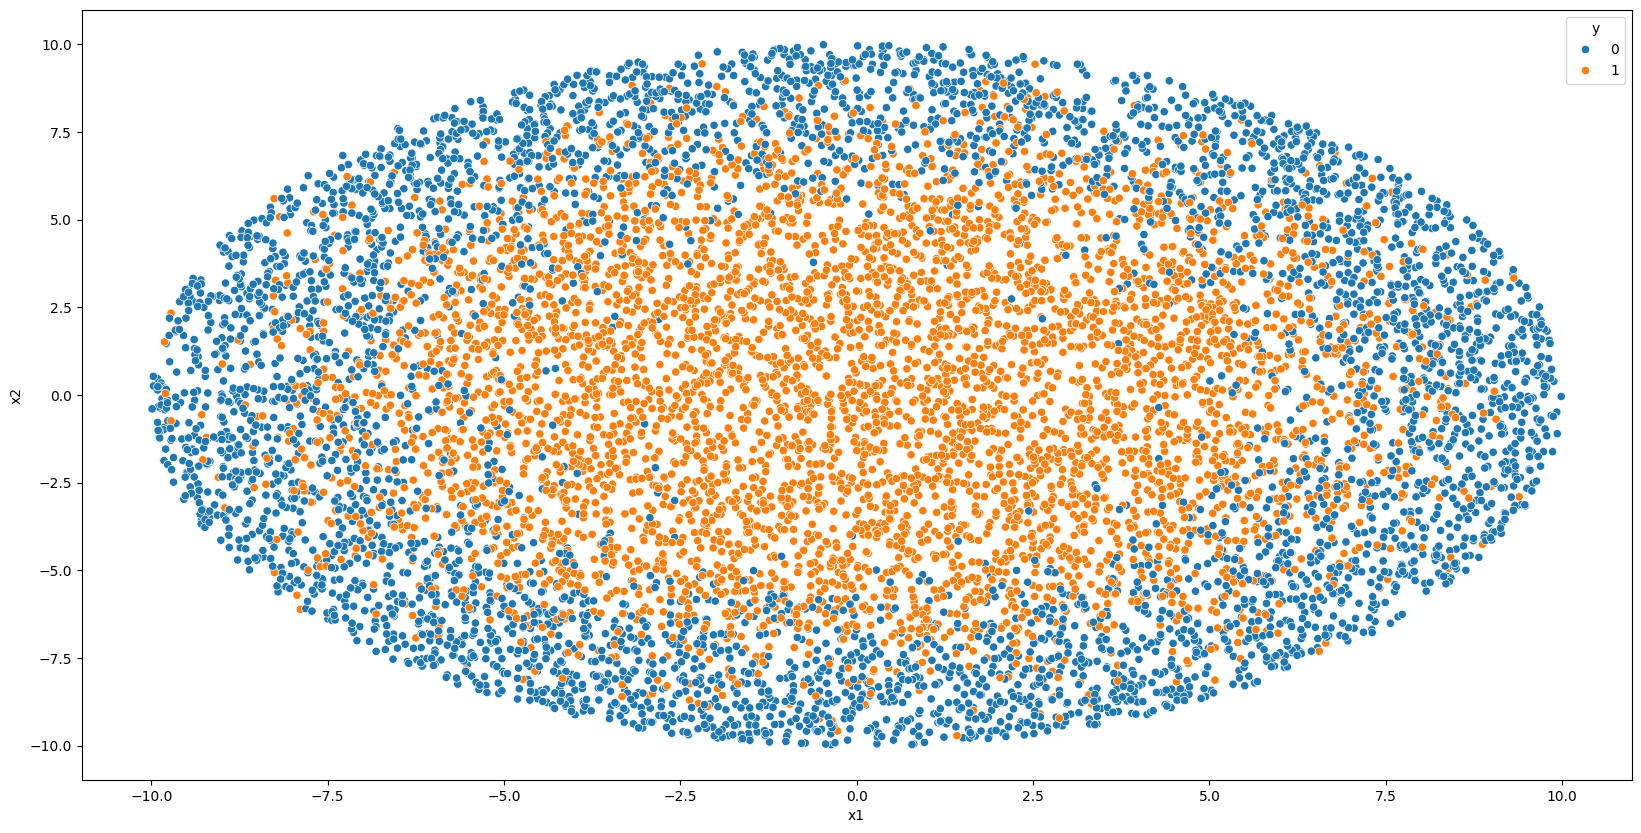

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x="x1", y="x2", hue="y", data=df)

Что можно сказать про эти данные?
1. Данные нелинейны, то есть нельзя провести прямую для разделения, то есть для классификации нужна нелинейная модель, например, многослойный перцептрон.
2. Двумерный набор данных (бинарная классификация), есть два класса : выделены оранжевым и голубым.
3. Ну мне кажется, что данные не очень сбалансированны.

После просмотра данных встает несколько вопросов:

 * 1) Можем ли мы построить идеальную модель ? (условная метрика точность)

 Ну прям 'идеальную' модель построить вряд ли сможем, так как точки двух классов очень тесно переплетены и связаны между собой (это видно по картинке). То есть в любом случае будет некая вероятность ошибки.

 * 2) Что ещё мы хотим знать о выборке?

Ответ выше.
 * 3) Какие алгоритмы машинного обучения мы можем эффективно здесь использовать?

 Так как у нас нелинейные данные, то можно использовать:

 - MLP (Многослойный перцептрон) - сможет смоделировать сложные нелинейные зависимости.

 - Метод опорных веркторов (SVM) - использовать ядро RBF - это нелинейное ядро может подойти для работы с нелинейными данными.

 - Деревья решений (Decision Trees) и ансамбли деревьев (Random Forest, Gradient Boosting): Деревья решений способны работать с нелинейными данными, а ансамбли деревьев часто улучшают производительность за счет агрегации предсказаний множества деревьев.

После описательного анализа приступим к построению моделей. Для начала посмотрим, что нам даст Логистическая регрессия.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
# разобьем выборку на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(df[['x1','x2']], df['y'], test_size=0.33)

In [ ]:
# Масштабирование:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression())
])

Точность нашей модели: 0.5663636363636364


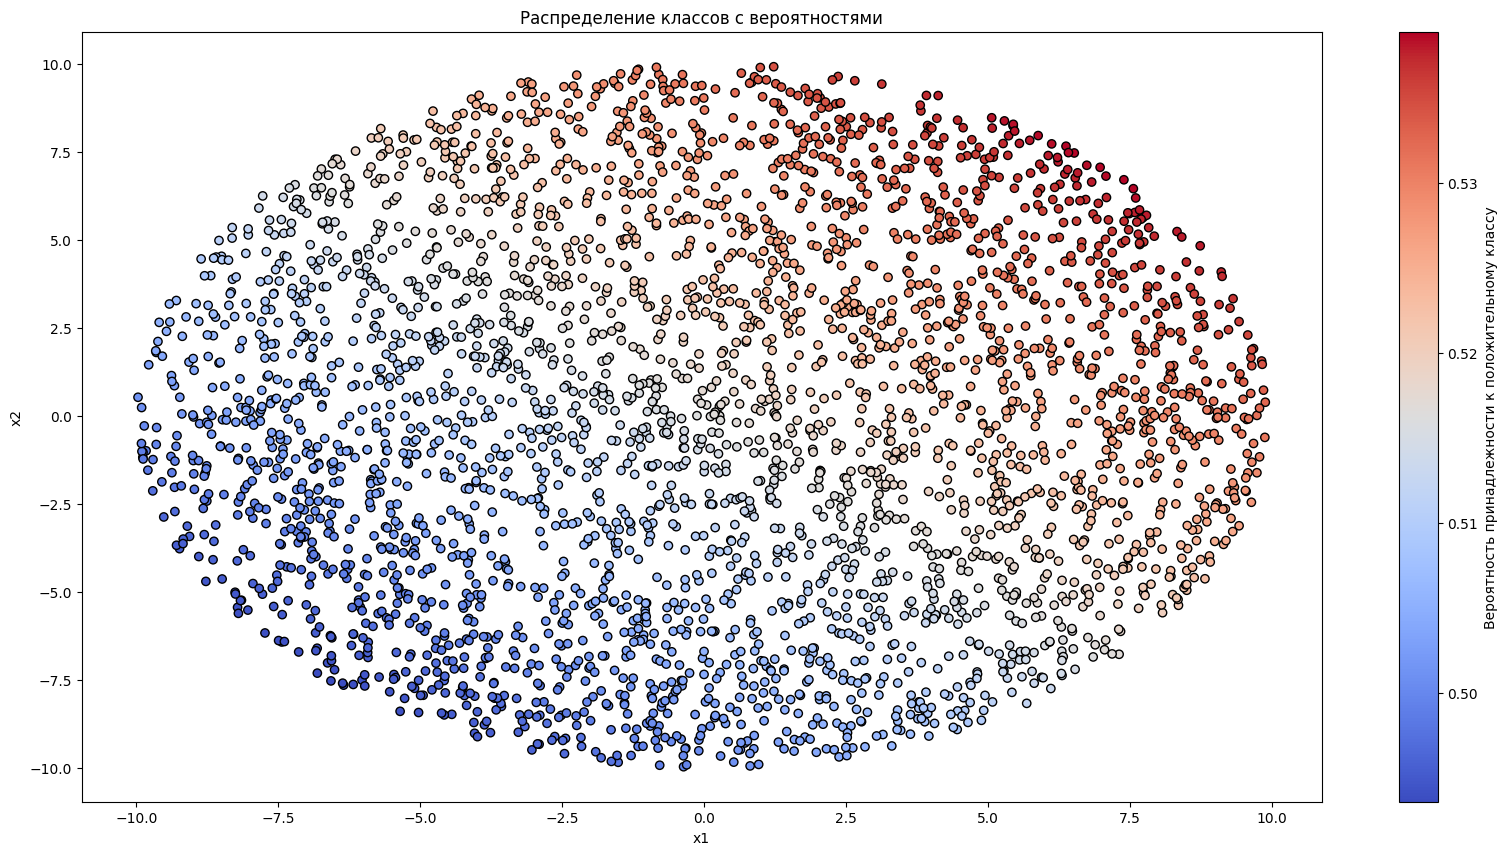

              precision    recall  f1-score   support

           0       0.89      0.16      0.27      1661
           1       0.53      0.98      0.69      1639

    accuracy                           0.57      3300
   macro avg       0.71      0.57      0.48      3300
weighted avg       0.71      0.57      0.48      3300



In [ ]:
model.fit(X_train, y_train)

predict_logit = model.predict(X_test)
predict_log_proba = model.predict_proba(X_test)[:, 1]

print(f'Точность нашей модели: {accuracy_score(y_test, predict_logit)}')

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_log_proba, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Вероятность принадлежности к положительному классу')
plt.title('Распределение классов с вероятностями')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

print(classification_report(y_test, predict_logit))

Вообще машинное обучение не только про алгоритмы (нейронные сети не исключение),
 а скорее про обработку данных. Что нам надо добавить, чтобы наш алгоритм отработал без проблем?

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   y       10000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 312.5 KB


In [ ]:
display(df.dtypes)

x1    float64
x2    float64
y       int64
dtype: object

In [ ]:
df_new = df.copy()



Для нелинейных данных ,во-первых, можно добавить полиномиальные признаки (то есть грубо говоря создаются признаки, которые захватывают нелинейные взаимодействия между исходными).
Можно использовать Евклидово расстояние (оно же используется для определение расстояния от одной точки до другой), нам это как раз тут нужно.
Формула:

В двух измерениях формула выглядит так: d(p, q) = √(p1 − q1)² + (p2 − q2)².

В трёх измерениях для точек, заданных их декартовыми координатами, расстояние равно d(p, q) = √(p1 − q1)² + (p2 − q2)² + (p3 − q3)²

In [ ]:
# Повторяем наш код, только с новыми фичами - смотрим на магию
# ваш код для фичей и новой модели

# у нас расстояние от центра имеет отношение к классу точки
df_new['new_feature_1'] = np.sqrt(df['x1']**2 + df['x2']**2) # посчитаю Евклидово расстояние, (расстояние каждой точки данных от начала координат)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new[['x1', 'x2', 'new_feature_1']], df_new['y'], test_size=0.33, random_state=40) # поставила еще random_state

model = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])

In [ ]:
model.fit(X_train_new, y_train_new)
predict_logit = model.predict(X_test_new)
predict_log_proba = model.predict_proba(X_test_new)[:, 1]
print(f'Точность нашей модели {accuracy_score(predict_logit,y_test_new)}')

Точность нашей модели 0.8512121212121212


In [ ]:
# Точность нашей модели 0.8512121212121212, это уже гораздо лучше

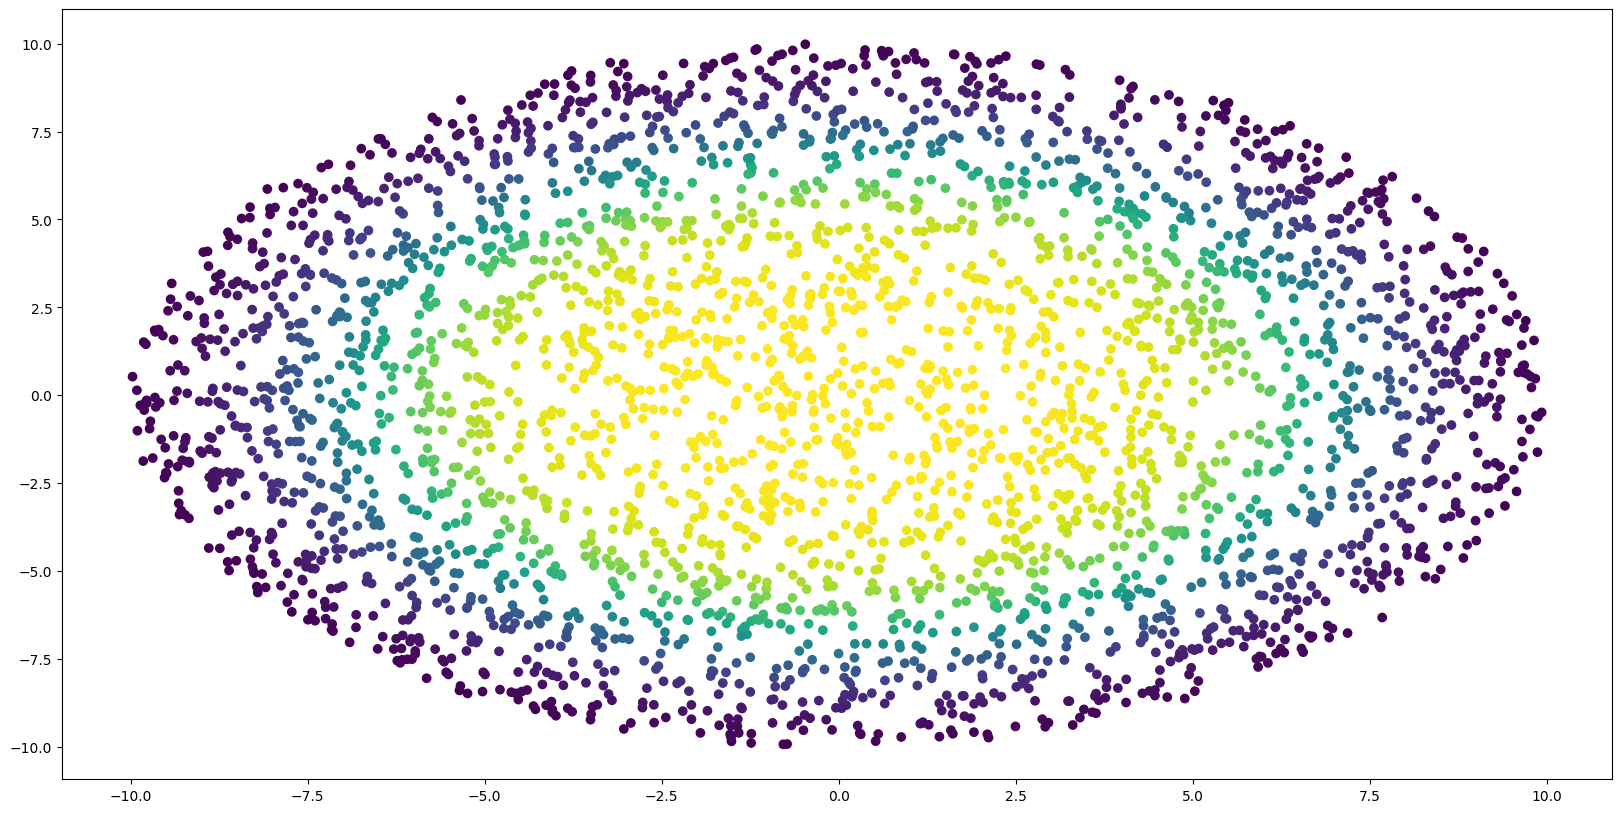

In [ ]:
plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_log_proba)
plt.show()

Переходим к следующему классу алгоритмов - деревья решений. Какая особенность есть у деревьев? Какой параметр надо зафикисировать, чтобы эта особенность не испортила обучение?

Деревья имеют свойство переобучаться, если хоть немножко неправильно поработаешь с параметрами. Для того чтобы это скорректировать, нужно установить дополнительные гиперпараметры, например max_depth, random_state, min_samples_leaf.

*Переобучение модели в машинном обучении и статистике — явление, когда построенная модель хорошо объясняет примеры из обучающей выборки, но относительно плохо работает на примерах, не участвовавших в обучении (на примерах из тестовой выборки).

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
# Попробую подобрать нужные параметры через гридсерч
X_train, X_test, y_train, y_test = train_test_split(df[['x1', 'x2']], df['y'], test_size=0.33, random_state=42)

param_grid = {
    'max_depth': range(1, 11),
    'min_samples_leaf': range(1, 10)}
# модель дерева решений с фиксированной глубиной
model_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(model_tree, param_grid, cv=4, scoring='accuracy') # cv = количество фолдов кросс-валидации
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Best parameters: {'max_depth': 8, 'min_samples_leaf': 4}
Best accuracy: 0.8243283582089552


In [ ]:
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.8221212121212121


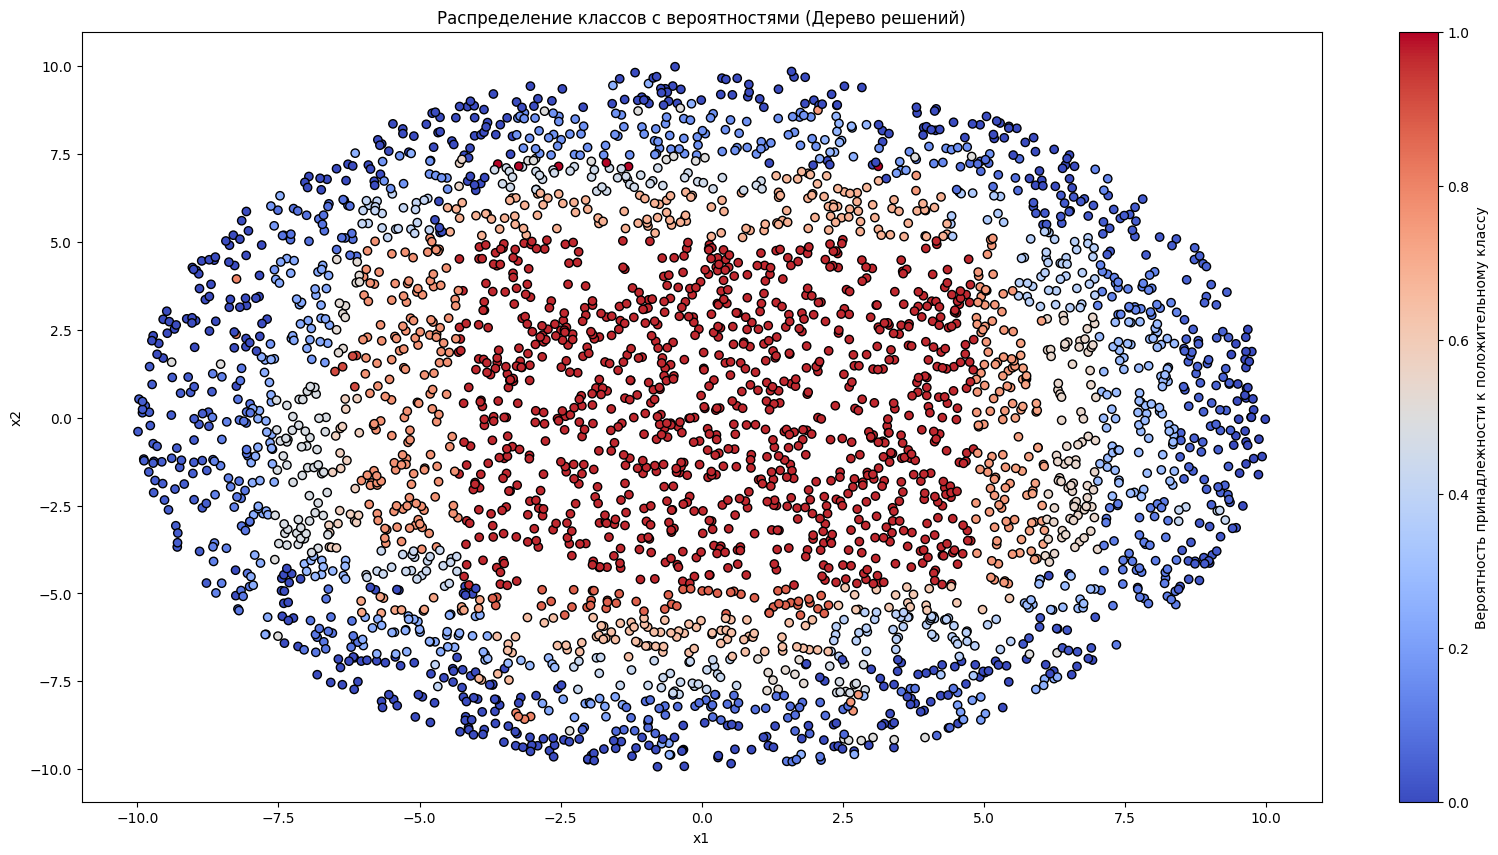

In [ ]:
#predict_tree = model_tree.predict(X_test)
#print(f'Точность нашей модели: {accuracy_score(y_test, predict_tree)}')
#predict_tree_proba = model_tree.predict_proba(X_test)[:, 1]

# вероятности для тестовой выборки
y_prob = best_model.predict_proba(X_test)[:, 1]  # вероятность положительного класса

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=y_prob, cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Вероятность принадлежности к положительному классу')
plt.title('Распределение классов с вероятностями (Дерево решений)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Поможет ли в данном случае ансамблирование? Когда в целом ансамбль дает хорошие результаты?

Точность нашей модели: 0.8287878787878787


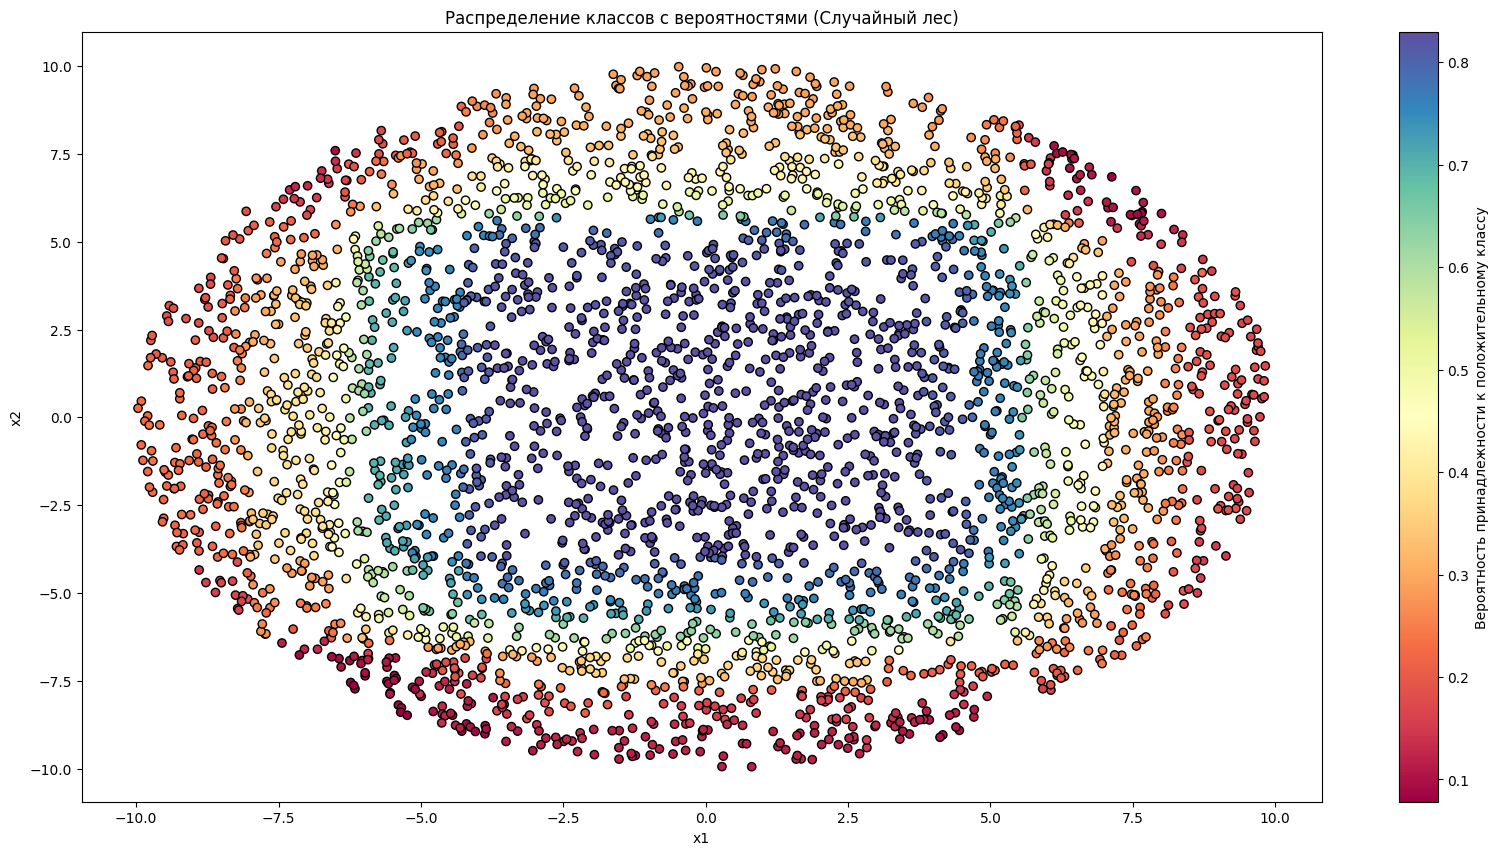

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# модель случайного леса
model_forest = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=42)

model_forest.fit(X_train, y_train)

predict_forest = model_forest.predict(X_test)
print(f'Точность нашей модели: {accuracy_score(y_test, predict_forest)}')

predict_forest_proba = model_forest.predict_proba(X_test)[:, 1]

plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_forest_proba, cmap='Spectral', edgecolor='k')
plt.colorbar(label='Вероятность принадлежности к положительному классу')
plt.title('Распределение классов с вероятностями (Случайный лес)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

ну и наконец мы добрались до нейронок - пора собрать нашу нейроночку под эту задачу.

Соберем простенькую нейронку - нам хватит 2х слоев по 5 нейронов в каждом.

In [1]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 12.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import torch.utils.data as data_utils
from torchmetrics import Accuracy

In [16]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=128,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=128,
                                        shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy())

In [17]:
input_size = 2
hidden_size = 5
output_size = 1
epochs = 100 # у нас совсем небольшой набор данных, поэтому лучше использовать от 50 до 100 эпох
learning_rate = 0.0001

In [18]:
class SimpleNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleNN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size) #2 и 5 (первый слой)
    self.fc2 = nn.Linear(hidden_size, hidden_size) # 5 и 5 (второй слой)
    self.fc3 = nn.Linear(hidden_size, output_size) # 5 и 1 (выходной слой)

  def forward(self, x):
    x = F.relu(self.fc1(x)) # RELU к 1 слою
    x = F.relu(self.fc2(x)) # RELU ко 2 слою
    x = torch.sigmoid(self.fc3(x)) # сигмоида на выходном слое для бинарной классификации
    return x

In [19]:
model = SimpleNN(input_size, hidden_size, output_size)

In [20]:
# Так как у нас задача похоже на задачу бинарной классиффикации, то лучше использовать BCEWithLogitsLoss, здесь используется сигмоида
criterion = torch.nn.BCEWithLogitsLoss() # Функция потерь
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas = (0.9, 0.999), eps=1e-08) # epsilon can prevent NaN errors (я не чистила пустые значения, вдруг здесь это не нужно, но перестраховать все же следует)

In [88]:
print(outputs.dtype)  # он везде требует torch.float32
print(labels.dtype)

torch.float32
torch.float32


In [89]:
labels = labels.float()  # Преобразование меток в float

In [90]:
outputs = outputs.float()  # Преобразование выходных данных в Float

In [22]:
# Обучение модели
for epoch in range(epochs):
  model.train()
  for inputs, labels in train_loader:
    optimizer.zero_grad() # Обнуляем градиенты
    outputs = model(inputs).squeeze()
    labels = labels.float()
    loss = criterion(outputs, labels) # вычисляется функция потерь
    loss.backward() # это обратное распорстранение ошибки
    optimizer.step() # обновление параметров
  print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.7284
Epoch [2/100], Loss: 0.7391
Epoch [3/100], Loss: 0.7594
Epoch [4/100], Loss: 0.6865
Epoch [5/100], Loss: 0.7385
Epoch [6/100], Loss: 0.7080
Epoch [7/100], Loss: 0.7482
Epoch [8/100], Loss: 0.7897
Epoch [9/100], Loss: 0.7710
Epoch [10/100], Loss: 0.6929
Epoch [11/100], Loss: 0.6645
Epoch [12/100], Loss: 0.7113
Epoch [13/100], Loss: 0.6745
Epoch [14/100], Loss: 0.7086
Epoch [15/100], Loss: 0.7247
Epoch [16/100], Loss: 0.6743
Epoch [17/100], Loss: 0.7180
Epoch [18/100], Loss: 0.6975
Epoch [19/100], Loss: 0.6422
Epoch [20/100], Loss: 0.6697
Epoch [21/100], Loss: 0.6817
Epoch [22/100], Loss: 0.7465
Epoch [23/100], Loss: 0.7335
Epoch [24/100], Loss: 0.7285
Epoch [25/100], Loss: 0.6623
Epoch [26/100], Loss: 0.6859
Epoch [27/100], Loss: 0.7403
Epoch [28/100], Loss: 0.7014
Epoch [29/100], Loss: 0.6990
Epoch [30/100], Loss: 0.6818
Epoch [31/100], Loss: 0.7169
Epoch [32/100], Loss: 0.6535
Epoch [33/100], Loss: 0.6540
Epoch [34/100], Loss: 0.6936
Epoch [35/100], Loss: 0

In [ ]:
# Что-то фигня какая-то, функция потерь на протяжении всего времени то снижается, то повышается, думаю, что результаты не достоверны, попробую еще раз

In [178]:
df_new = df.copy()

In [179]:
display(df.dtypes)

x1    float64
x2    float64
y       int64
dtype: object

In [249]:
X_train, X_test, y_train, y_test = train_test_split(df[['x1','x2']], df['y'], test_size=0.33)

In [105]:
# разобьем выборку на трейн/тест
def create_data_loader(X_train, y_train, X_test, y_test):
    # Преобразуем метки в целочисленный формат
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=128,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=128,
                                        shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy())

In [106]:
input_size = 2
hidden_size = 5
output_size = 1
epochs = 100 # у нас совсем небольшой набор данных, поэтому лучше использовать от 50 до 100 эпох
learning_rate = 0.00001 # уменьшила learning_rate, и увеличила batch_size

In [107]:
class SimpleNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleNN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size) #2 и 5 (первый слой)
    self.fc2 = nn.Linear(hidden_size, hidden_size) # 5 и 5 (второй слой)
    self.fc3 = nn.Linear(hidden_size, output_size) # 5 и 1 (выходной слой)

  def forward(self, x):
    x = F.relu(self.fc1(x)) # RELU к 1 слою
    x = F.relu(self.fc2(x)) # RELU ко 2 слою
    x = torch.sigmoid(self.fc3(x)) # сигмоида на выходном слое для бинарной классификации
    return x

In [108]:
model = SimpleNN(input_size, hidden_size, output_size)

In [109]:
criterion = nn.BCEWithLogitsLoss()  # Используем BCEWithLogitsLoss
accuracy = Accuracy(task="multiclass", num_classes=3, top_k=2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [111]:
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)  #  функцию потерь
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновление параметров

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.7314
Epoch [2/100], Loss: 0.7604
Epoch [3/100], Loss: 0.6961
Epoch [4/100], Loss: 0.7232
Epoch [5/100], Loss: 0.7825
Epoch [6/100], Loss: 0.7222
Epoch [7/100], Loss: 0.7613
Epoch [8/100], Loss: 0.7392
Epoch [9/100], Loss: 0.7677
Epoch [10/100], Loss: 0.6628
Epoch [11/100], Loss: 0.7177
Epoch [12/100], Loss: 0.7810
Epoch [13/100], Loss: 0.7569
Epoch [14/100], Loss: 0.6886
Epoch [15/100], Loss: 0.7169
Epoch [16/100], Loss: 0.7922
Epoch [17/100], Loss: 0.7140
Epoch [18/100], Loss: 0.7094
Epoch [19/100], Loss: 0.7212
Epoch [20/100], Loss: 0.7158
Epoch [21/100], Loss: 0.7047
Epoch [22/100], Loss: 0.6787
Epoch [23/100], Loss: 0.7459
Epoch [24/100], Loss: 0.7730
Epoch [25/100], Loss: 0.7401
Epoch [26/100], Loss: 0.6909
Epoch [27/100], Loss: 0.7393
Epoch [28/100], Loss: 0.7411
Epoch [29/100], Loss: 0.6741
Epoch [30/100], Loss: 0.7718
Epoch [31/100], Loss: 0.6720
Epoch [32/100], Loss: 0.6674
Epoch [33/100], Loss: 0.7152
Epoch [34/100], Loss: 0.7210
Epoch [35/100], Loss: 0

In [ ]:
# пробую еще раз, мне не нравится тот, факт, что потеря падает, а потом повышается

In [250]:
# разобьем выборку на трейн/тест
def create_data_loader(X_train, y_train, X_test, y_test):
    # Преобразуем метки в целочисленный формат
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=128,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=128,
                                        shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy())
# batch_size до 128

In [251]:
input_size = 2
hidden_size = 5
output_size = 1
epochs = 200 # увеличу эпоху
learning_rate = 0.001 # увеличу шаг

In [252]:
class SimpleNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleNN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size) #2 и 5 (первый слой)
    self.fc2 = nn.Linear(hidden_size, hidden_size) # 5 и 5 (второй слой)
    self.fc3 = nn.Linear(hidden_size, output_size) # 5 и 1 (выходной слой)

  def forward(self, x):
    x = F.relu(self.fc1(x)) # RELU к 1 слою
    x = F.relu(self.fc2(x)) # RELU ко 2 слою
    x = torch.sigmoid(self.fc3(x))
     # сигмоида убирается
    return x

In [253]:
model = SimpleNN(input_size, hidden_size, output_size)

In [254]:
criterion = nn.BCEWithLogitsLoss()  # у нас сигмоида, все-таки лучше LogitsLoss
accuracy = Accuracy(task='multiclass', num_classes=2)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # поменяю SGD на Adam

In [255]:
for epoch in range(epochs):
  model.train()
  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs).squeeze()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/200], Loss: 0.7041
Epoch [2/200], Loss: 0.7192
Epoch [3/200], Loss: 0.7113
Epoch [4/200], Loss: 0.6796
Epoch [5/200], Loss: 0.6872
Epoch [6/200], Loss: 0.6964
Epoch [7/200], Loss: 0.6856
Epoch [8/200], Loss: 0.6751
Epoch [9/200], Loss: 0.6608
Epoch [10/200], Loss: 0.6763
Epoch [11/200], Loss: 0.6821
Epoch [12/200], Loss: 0.6835
Epoch [13/200], Loss: 0.6668
Epoch [14/200], Loss: 0.6745
Epoch [15/200], Loss: 0.6542
Epoch [16/200], Loss: 0.6680
Epoch [17/200], Loss: 0.6625
Epoch [18/200], Loss: 0.6075
Epoch [19/200], Loss: 0.6131
Epoch [20/200], Loss: 0.6459
Epoch [21/200], Loss: 0.6354
Epoch [22/200], Loss: 0.6256
Epoch [23/200], Loss: 0.5924
Epoch [24/200], Loss: 0.6690
Epoch [25/200], Loss: 0.6283
Epoch [26/200], Loss: 0.6141
Epoch [27/200], Loss: 0.5971
Epoch [28/200], Loss: 0.6222
Epoch [29/200], Loss: 0.5452
Epoch [30/200], Loss: 0.5864
Epoch [31/200], Loss: 0.5703
Epoch [32/200], Loss: 0.5706
Epoch [33/200], Loss: 0.6052
Epoch [34/200], Loss: 0.6129
Epoch [35/200], Loss: 0

In [ ]:
# Другое дело, как только поменяла на Adam, loss стало меньше

In [256]:
# Оценка модели на тестовой выборке
model.eval()
with torch.no_grad():
  test_scores = model(torch.tensor(X_test.to_numpy().astype(np.float32)))
  y_pred = []
  for inputs, _ in test_loader:
    outputs = model(inputs).squeeze()
    predicted = (outputs > 0.5).float()  # вероятности в классы
    y_pred.extend(predicted.numpy())

In [257]:
# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8397
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1630
           1       0.90      0.77      0.83      1670

    accuracy                           0.84      3300
   macro avg       0.85      0.84      0.84      3300
weighted avg       0.85      0.84      0.84      3300



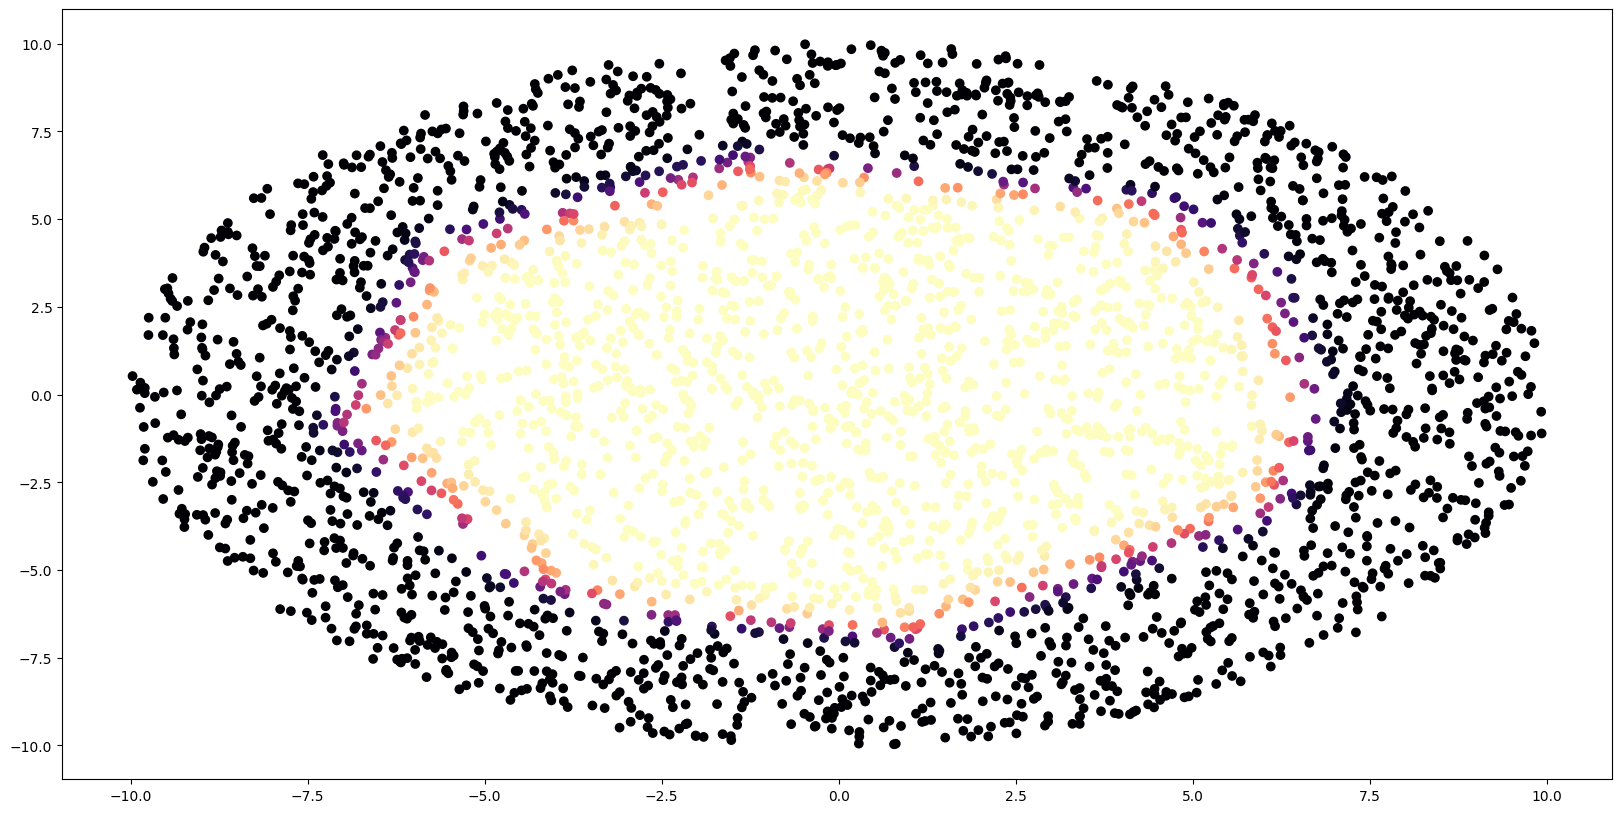

In [258]:
plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=test_scores, cmap='magma')
plt.show()

In [ ]:
# получилось что-то странное, возможно, я где-то не учла какие-то параметры, начну с самого начала


**Финальный вариант 1**

In [332]:
X_train, X_test, y_train, y_test = train_test_split(df[['x1','x2']], df['y'], test_size=0.33)

In [333]:
# преобразую все данные в int, так как с ними удобнее работать
import torch
from torch.utils import data as data_utils
import numpy as np

def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(
        torch.tensor(X_train.astype(np.float32)),  #  X_train в int
        torch.tensor(y_train.astype(np.float32))   #  y_train в int
    )
    train_loader = data_utils.DataLoader(
        dataset=train_tensor,
        batch_size=64,
        shuffle=True
    )

    test_tensor = data_utils.TensorDataset(
        torch.tensor(X_test.astype(np.float32)),   #  X_test в int
        torch.tensor(y_test.astype(np.float32))     #  y_test в int
    )
    test_loader = data_utils.DataLoader(
        dataset=test_tensor,
        batch_size=64,
        shuffle=False
    )
    return train_loader, test_loader


train_loader, test_loader = create_data_loader(
    X_train.to_numpy(),
    y_train.to_numpy(),
    X_test.to_numpy(),
    y_test.to_numpy()
)

In [334]:
input_size = 2
hidden_size = 5
output_size = 1
epochs = 100 # опять уменьшу эпоху, датасет-то маленький
learning_rate = 0.001 # сделаю шаг меньше

In [335]:
class SimpleNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleNN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size) #2 и 5 (первый слой)
    self.fc2 = nn.Linear(hidden_size, hidden_size) # 5 и 5 (второй слой)
    self.fc3 = nn.Linear(hidden_size, output_size) # 5 и 1 (выходной слой)

  def forward(self, x):
    x = F.relu(self.fc1(x)) # RELU к 1 слою
    x = F.relu(self.fc2(x)) # RELU ко 2 слою
    x = torch.sigmoid(self.fc3(x)) # сигмоида на выходном слое для бинарной классификации
    return x

In [336]:
model = SimpleNN(input_size, hidden_size, output_size)

In [337]:
criterion = nn.BCELoss()
accuracy = Accuracy(task='multiclass', num_classes=2)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [338]:
for epoch in range(epochs):
  model.train()
  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs).squeeze()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.7206
Epoch [2/100], Loss: 0.6695
Epoch [3/100], Loss: 0.6665
Epoch [4/100], Loss: 0.6556
Epoch [5/100], Loss: 0.5858
Epoch [6/100], Loss: 0.5797
Epoch [7/100], Loss: 0.4881
Epoch [8/100], Loss: 0.4838
Epoch [9/100], Loss: 0.4356
Epoch [10/100], Loss: 0.4876
Epoch [11/100], Loss: 0.3455
Epoch [12/100], Loss: 0.3222
Epoch [13/100], Loss: 0.3722
Epoch [14/100], Loss: 0.4647
Epoch [15/100], Loss: 0.4682
Epoch [16/100], Loss: 0.3860
Epoch [17/100], Loss: 0.3450
Epoch [18/100], Loss: 0.3446
Epoch [19/100], Loss: 0.4877
Epoch [20/100], Loss: 0.4137
Epoch [21/100], Loss: 0.2904
Epoch [22/100], Loss: 0.5237
Epoch [23/100], Loss: 0.3067
Epoch [24/100], Loss: 0.2587
Epoch [25/100], Loss: 0.3137
Epoch [26/100], Loss: 0.3526
Epoch [27/100], Loss: 0.4325
Epoch [28/100], Loss: 0.2182
Epoch [29/100], Loss: 0.2841
Epoch [30/100], Loss: 0.3442
Epoch [31/100], Loss: 0.3457
Epoch [32/100], Loss: 0.2910
Epoch [33/100], Loss: 0.3284
Epoch [34/100], Loss: 0.2809
Epoch [35/100], Loss: 0

In [339]:
# Оценка модели на тестовой выборке
model.eval()
with torch.no_grad():
  test_scores = model(torch.tensor(X_test.to_numpy().astype(np.float32)))
  y_pred = []
  for inputs, _ in test_loader:
    outputs = model(inputs).squeeze()
    predicted = (outputs > 0.5).float()  # вероятности в классы
    y_pred.extend(predicted.numpy())

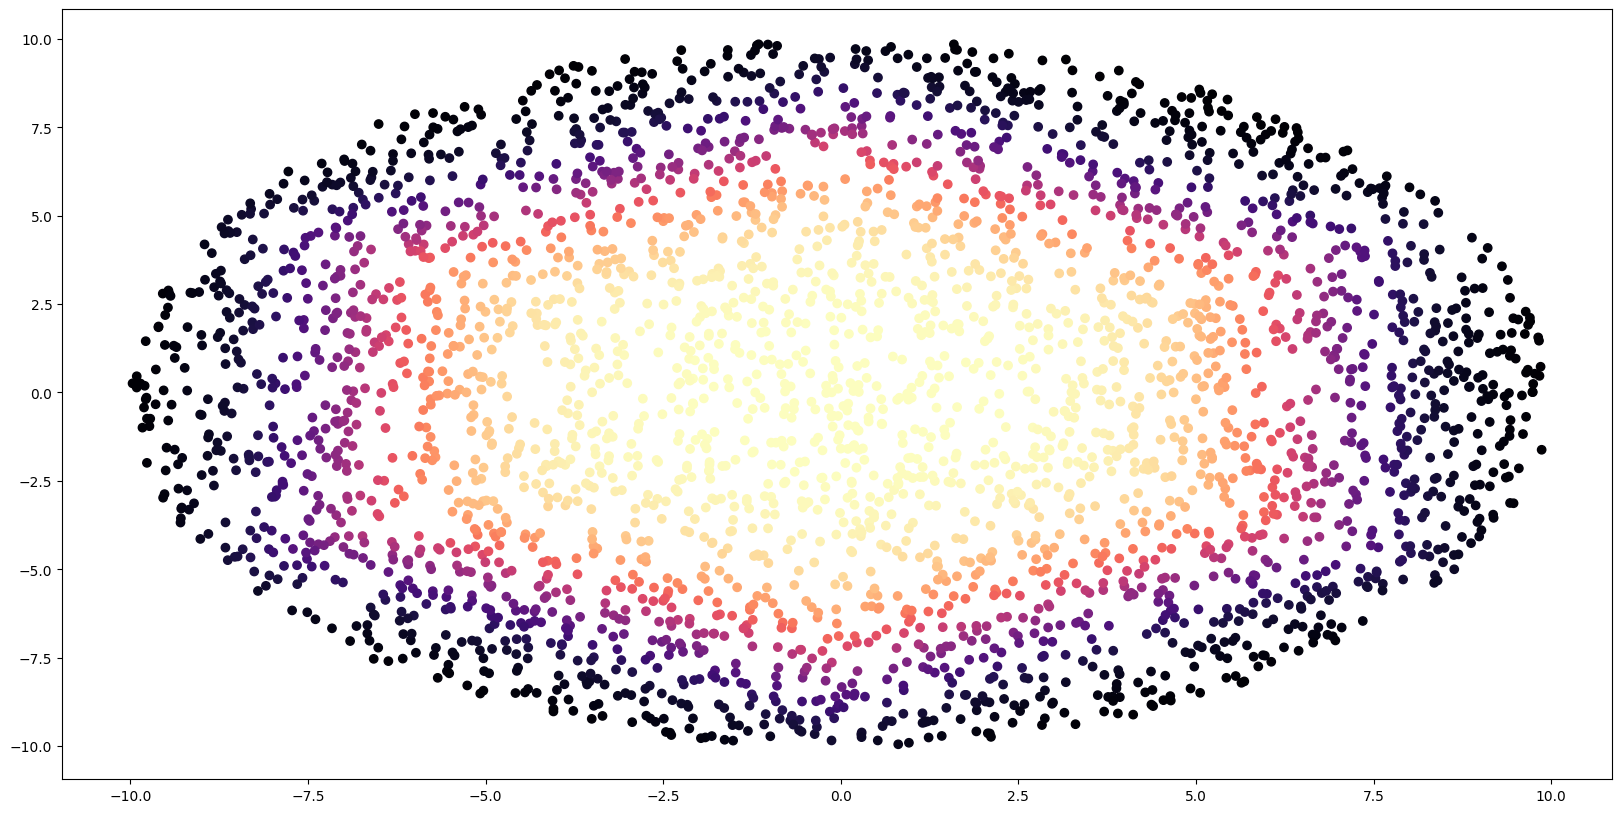

In [340]:
plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=test_scores, cmap='magma')
plt.show()

In [ ]:
# все еще не то, что мне нужно, так как неправильно были распознаны некоторые точки


**Финальный вариант 2**

In [380]:
X_train, X_test, y_train, y_test = train_test_split(df[['x1','x2']], df['y'], test_size=0.33)

In [381]:
# разобьем выборку на трейн/тест
def create_data_loader(X_train, y_train, X_test, y_test):
    # Преобразуем метки в целочисленный формат
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=64,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=64,
                                        shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy())
# batch_size до 64

In [382]:
input_size = 2
hidden_size = 5
output_size = 1
epochs = 100
learning_rate = 0.01 # увеличу learning_rate и попробую с SGD optimizer

In [383]:
class SimpleNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(SimpleNN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size) #2 и 5 (первый слой)
    self.fc2 = nn.Linear(hidden_size, hidden_size) # 5 и 5 (второй слой)
    self.fc3 = nn.Linear(hidden_size, output_size) # 5 и 1 (выходной слой)

  def forward(self, x):
    x = F.relu(self.fc1(x)) # RELU к 1 слою
    x = F.relu(self.fc2(x)) # RELU ко 2 слою
    x = torch.sigmoid(self.fc3(x)) # сигмоида на выходном слое для бинарной классификации
    return x

In [384]:
model = SimpleNN(input_size, hidden_size, output_size)

In [385]:
criterion = nn.BCELoss()
accuracy = Accuracy(task='multiclass', num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # поменяю опять на SGD

In [386]:
for epoch in range(epochs):
  model.train()
  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs).squeeze()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.7036
Epoch [2/100], Loss: 0.6975
Epoch [3/100], Loss: 0.6854
Epoch [4/100], Loss: 0.6805
Epoch [5/100], Loss: 0.6486
Epoch [6/100], Loss: 0.6437
Epoch [7/100], Loss: 0.6557
Epoch [8/100], Loss: 0.5717
Epoch [9/100], Loss: 0.6303
Epoch [10/100], Loss: 0.6408
Epoch [11/100], Loss: 0.5597
Epoch [12/100], Loss: 0.5996
Epoch [13/100], Loss: 0.5380
Epoch [14/100], Loss: 0.5182
Epoch [15/100], Loss: 0.5316
Epoch [16/100], Loss: 0.5152
Epoch [17/100], Loss: 0.4615
Epoch [18/100], Loss: 0.4284
Epoch [19/100], Loss: 0.3965
Epoch [20/100], Loss: 0.4919
Epoch [21/100], Loss: 0.5362
Epoch [22/100], Loss: 0.5004
Epoch [23/100], Loss: 0.3598
Epoch [24/100], Loss: 0.4342
Epoch [25/100], Loss: 0.4133
Epoch [26/100], Loss: 0.5260
Epoch [27/100], Loss: 0.5465
Epoch [28/100], Loss: 0.3377
Epoch [29/100], Loss: 0.2669
Epoch [30/100], Loss: 0.3788
Epoch [31/100], Loss: 0.2933
Epoch [32/100], Loss: 0.3218
Epoch [33/100], Loss: 0.3542
Epoch [34/100], Loss: 0.4206
Epoch [35/100], Loss: 0

In [387]:
# Оценка модели на тестовой выборке
model.eval()
with torch.no_grad():
  test_scores = model(torch.tensor(X_test.to_numpy().astype(np.float32)))
  y_pred = []
  for inputs, _ in test_loader:
    outputs = model(inputs).squeeze()
    predicted = (outputs > 0.5).float()  # вероятности в классы
    y_pred.extend(predicted.numpy())

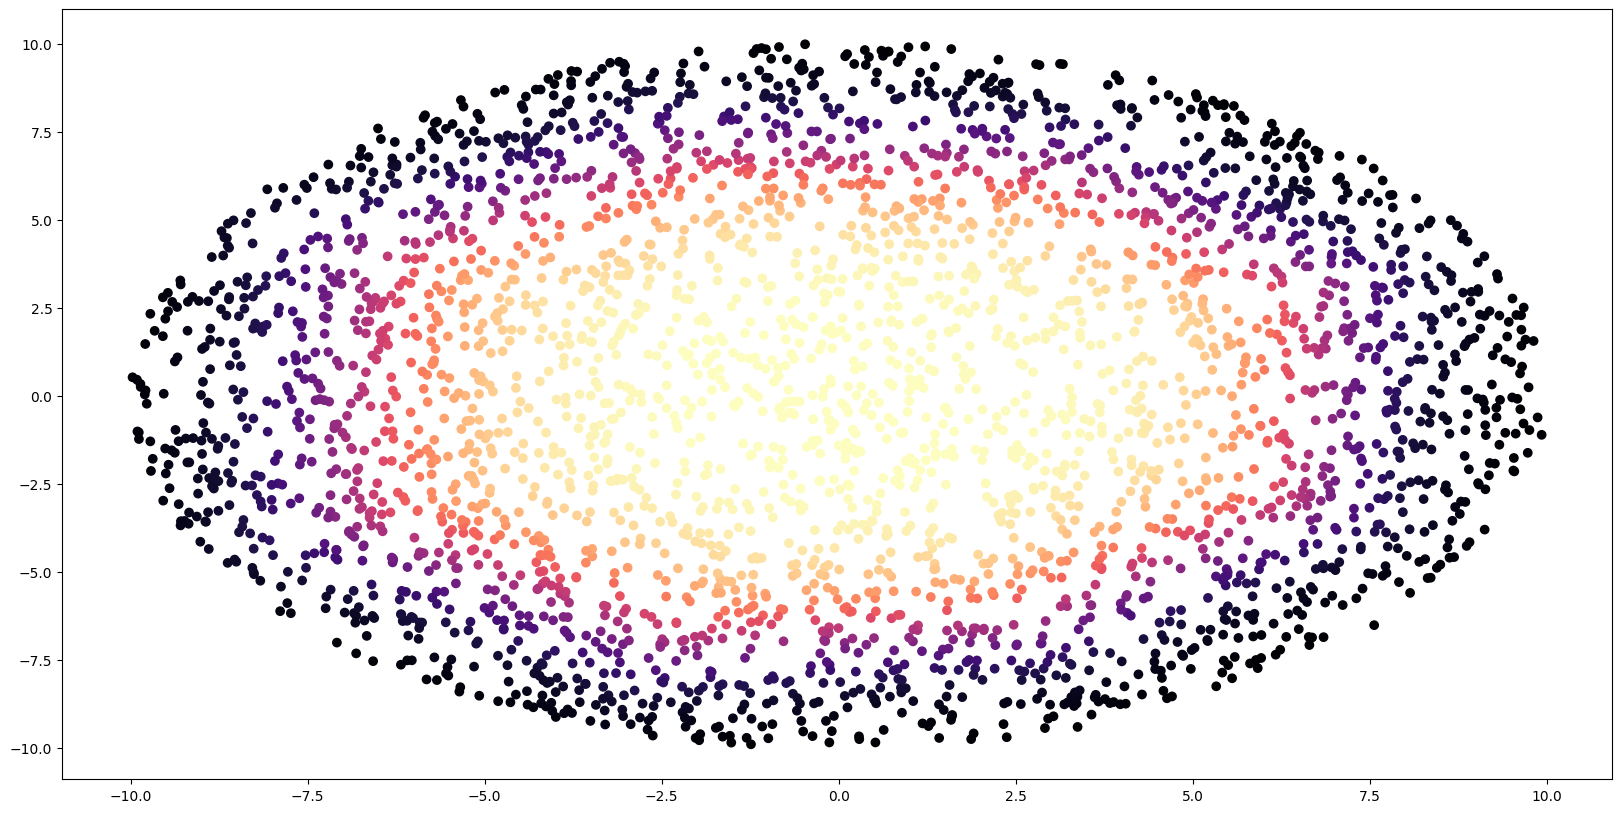

In [388]:
plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=test_scores, cmap='magma')
plt.show()

Далеко не идеально, выводы, которые я сделала:
- в данном случае нужно было, наоборот, уменьшить batch_size до 64
- epoch до 100, т.к маленький датасет

- использовала в оптимизаторе Adam, SGD дает достаточно высокую Loss, (более того, в Adam уверена больше, т.к меня очень смутило, что как только в самом последнем случае я увеличила learning_rate, у меня стали лучше результаты с SGD). Обычно же нужно его наоборот уменьшать.

- кроме того, задача бинарной классиффикации - лучше использовать criterion = nn.BCELoss()

Если посчитаете, что сделано недостаточно для нормального балла, то дайте пожалуйста фидбек, возможно, придется переделать.